In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import os
module_path = os.path.abspath(os.path.join('..', '..', '..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras.models import load_model

from Preprocessing import load_and_preprocess_data
from ModelTuner import HyperparameterTuner
from Models import MultiOutputLSTMHyperModel
from Training import MultiTaskModelTrainer
from Plotter import outbreak_plot

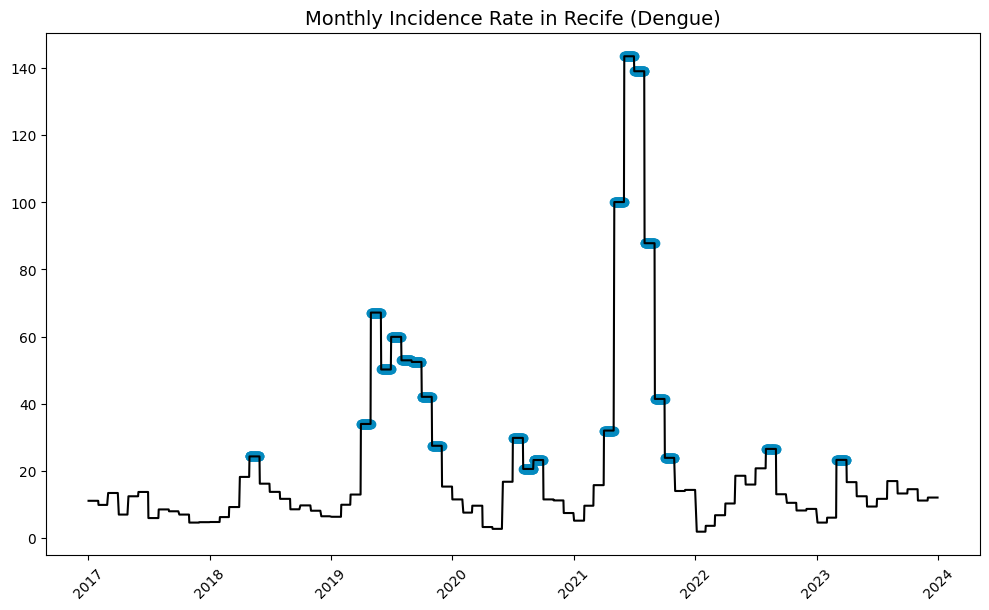

In [7]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                        
    np.random.seed(seed)                     
    tf.random.set_seed(seed)                  

set_seed(42)

pd.set_option('display.max_columns', None)

numeric_columns = ['POPULACAO', 'NUM_CASOS_SEM', 'TAXA_INC_SEM', 'TAXA_INC_MES', 'NUM_CASOS_DIARIOS']
target_column_class = 'SURTO'
target_column_regress = 'NUM_CASOS_MES'
timestamp_column = 'DT_NOTIFIC'

FILEPATH = '../../../data/dengue_recife.parquet'
WINDOW_SIZE = 60
PRED_STEPS = 30

df = pd.read_parquet(FILEPATH)

df, X, scaler, scaler_y, X_train, X_test, y_train_class, y_test_class, y_train_regress, y_test_regress, timestamp = load_and_preprocess_data(
    FILEPATH, WINDOW_SIZE, numeric_columns, target_column_class, target_column_regress, timestamp_column, 'dengue'
)

outbreak_plot(df, 'Dengue')

In [ ]:
model_builder_lstm_simple = MultiOutputLSTMHyperModel(WINDOW_SIZE, X_train.shape[2], PRED_STEPS) 
tuner_lstm_simple = HyperparameterTuner(model_builder_lstm_simple, X_train, y_train_class, y_train_regress, 42)
best_model_lstm = tuner_lstm_simple.tune_and_validate("lstm.h5")

In [ ]:
best_model_lstm = load_model('lstm.h5')

In [9]:
best_model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 384)       │    599,040 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 416)       │    160,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 416)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │        417 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 30)        │     12,510 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 772,129 (2.95 MB)

 Trainable params: 772,127 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [10]:
training_lstm_simple = MultiTaskModelTrainer(best_model_lstm, X_train, y_train_class, y_train_regress, X_test, y_test_class, y_test_regress, timestamp)
training_lstm_simple.compile_model()
training_lstm_simple.train()

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - classification_accuracy: 1.0000 - classification_loss: 0.0039 - loss: 0.0054 - regression_loss: 0.0015 - regression_mae: 0.0311 - val_classification_accuracy: 0.9033 - val_classification_loss: 0.3976 - val_loss: 0.3703 - val_regression_loss: 0.0012 - val_regression_mae: 0.0245 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - classification_accuracy: 1.0000 - classification_loss: 2.3171e-05 - loss: 0.0012 - regression_loss: 0.0012 - regression_mae: 0.0269 - val_classification_accuracy: 0.9033 - val_classification_loss: 0.2852 - val_loss: 0.2646 - val_regression_loss: 0.0011 - val_regression_mae: 0.0223 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - classification_accuracy: 1.0000 - classification_loss: 2.1989e-04 - loss: 8.9488e-04 - regression_loss: 6.7380e-04 - regression_mae: 0.0207 - val_classification_accuracy: 0.9033 - val_classification_loss: 0.3196 - val_loss: 0.3

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - classification_accuracy: 0.9154 - classification_loss: 0.3475 - loss: 0.3502 - regression_loss: 3.8109e-04 - regression_mae: 0.0108     
Resultados no teste: [0.20093438029289246, 0.18705421686172485, 0.0002320256899110973, 0.9512194991111755, 0.008802546188235283]
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       297
           1       0.86      0.58      0.69        31

    accuracy                           0.95       328
   macro avg       0.91      0.79      0.83       328
weighted avg       0.95      0.95      0.95       328

Matriz de Confusão:
[[294   3]
 [ 13  18]]
Metrics Results:
   Precision    Recall  F1-Score        MAE          MSE       RMSE    MedAPE  \
0   0.857143  0.580645  0.692308  20.379897  1410.349745  37.554623  6.147014   

       MAPE   ROC AUC  
0  9.575076  0.923211  


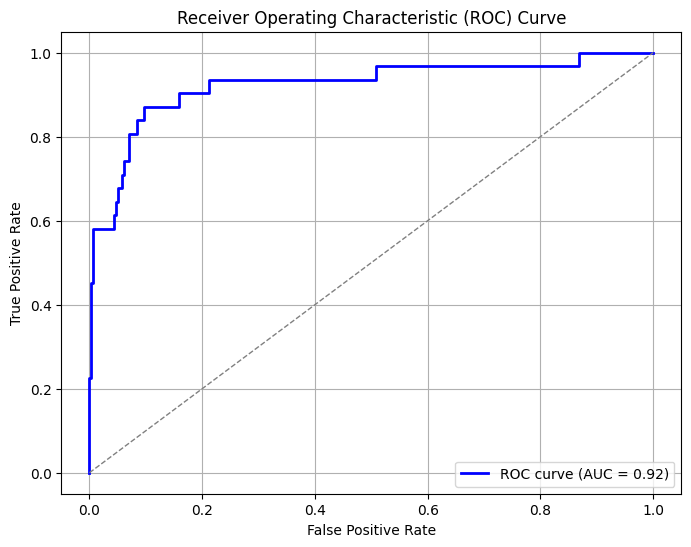

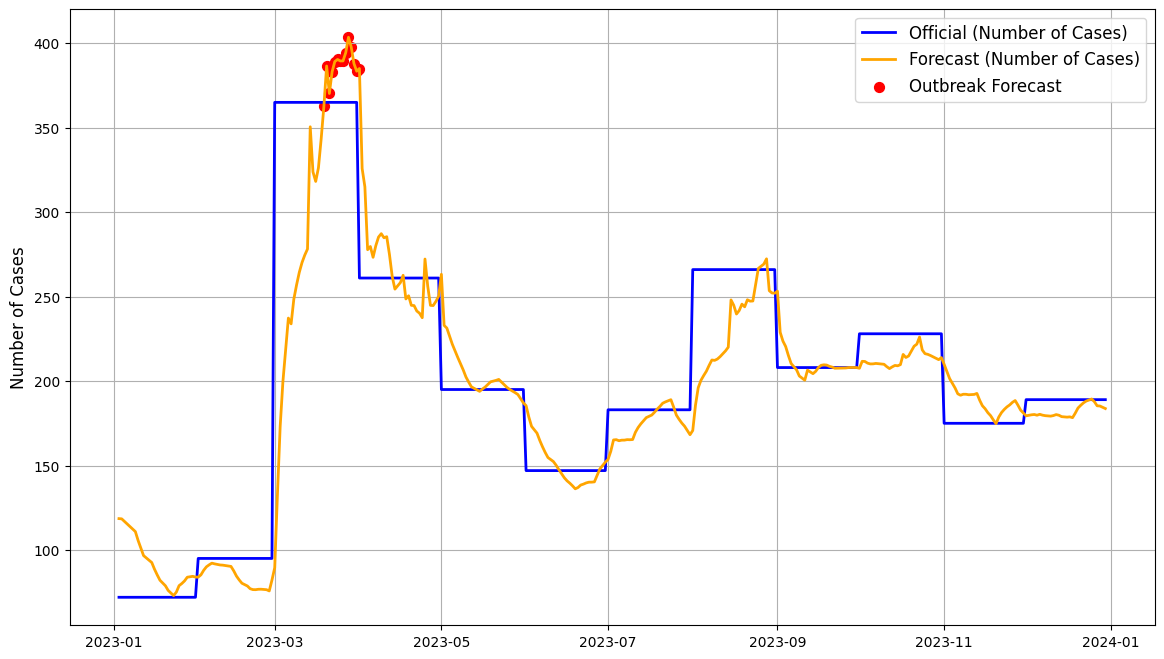

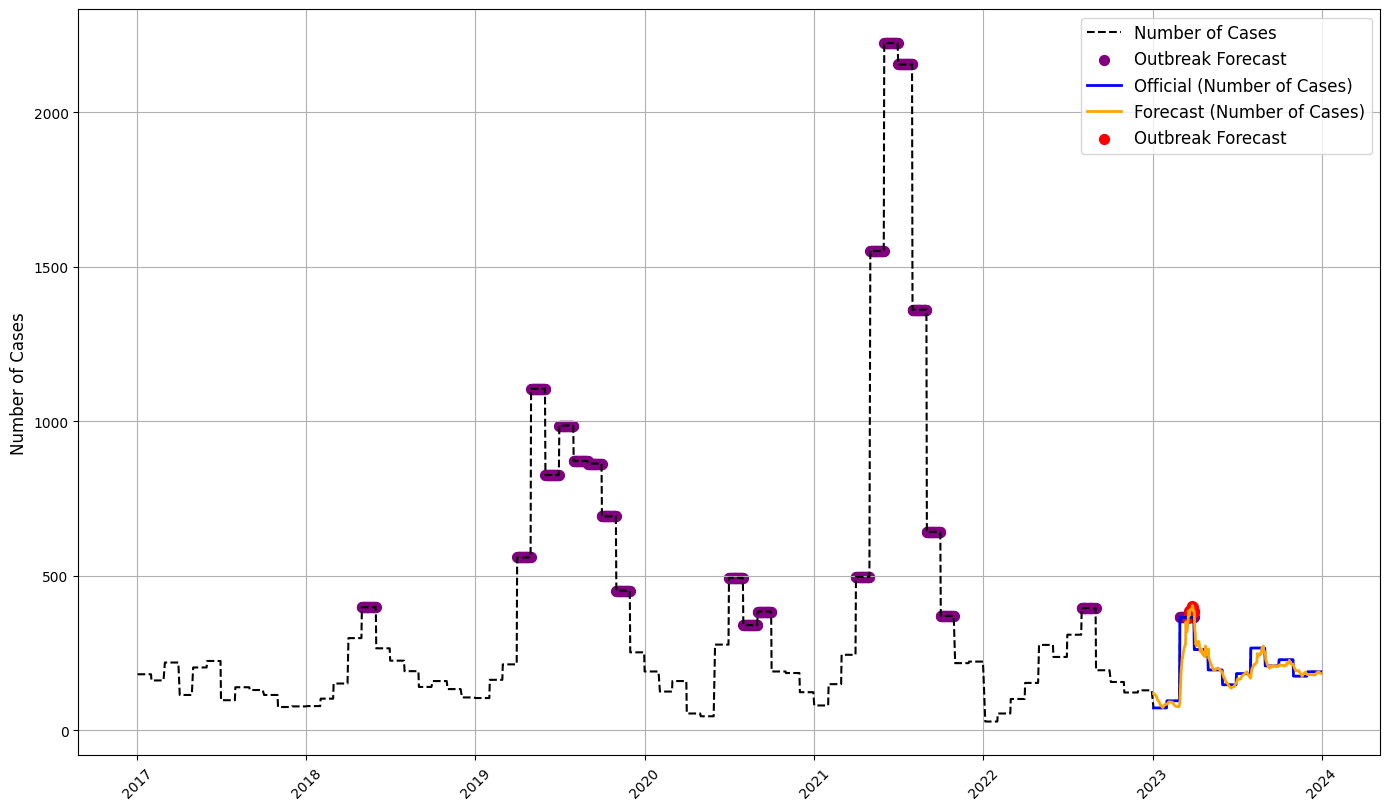

In [14]:
y_test_class, y_test_regress, y_pred_class, y_pred_reg = training_lstm_simple.evaluate()
training_lstm_simple.plot_predictions(scaler_y)
training_lstm_simple.plot_predictions_with_historical(scaler_y, df)

In [12]:
training_lstm_simple.bootstrap_evaluation(y_test_class, y_pred_class, y_test_regress, y_pred_reg)

([np.float64(1.0),
  np.float64(0.8421052631578947),
  np.float64(0.782608695652174),
  np.float64(0.8125),
  np.float64(0.9166666666666666),
  np.float64(0.7058823529411765),
  np.float64(0.9130434782608695),
  np.float64(0.85),
  np.float64(0.8571428571428571),
  np.float64(0.9565217391304348),
  np.float64(0.9375),
  np.float64(0.85),
  np.float64(0.9166666666666666),
  np.float64(0.9285714285714286),
  np.float64(0.8333333333333334),
  np.float64(0.7272727272727273),
  np.float64(0.8571428571428571),
  np.float64(0.782608695652174),
  np.float64(0.9545454545454546),
  np.float64(0.7222222222222222),
  np.float64(0.8),
  np.float64(0.88),
  np.float64(1.0),
  np.float64(0.75),
  np.float64(0.9166666666666666),
  np.float64(0.7692307692307693),
  np.float64(0.8),
  np.float64(0.8064516129032258),
  np.float64(1.0),
  np.float64(0.8333333333333334),
  np.float64(0.75),
  np.float64(0.8260869565217391),
  np.float64(0.88),
  np.float64(0.8),
  np.float64(0.7),
  np.float64(0.9230769230